In [5]:
from data import SOLD_HOUSE_PRICES
import pandas as pd
import numpy as np

from sklearn.neighbors import KernelDensity
from scipy.interpolate import griddata
from numpy import linspace
import matplotlib.pyplot as plt

In [2]:
sellprices_df = pd.read_csv(SOLD_HOUSE_PRICES)

/tmp/ipykernel_19303/1575736277.py:1: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  sellprices_df = pd.read_csv(SOLD_HOUSE_PRICES)


In [3]:
sellprices_df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2022-1,2022-01-03,1,Vente,55000.0,13.0,NaN,RUE DE LA LIBERTE,2280,1000.0,...,Appartement,24.0,1.0,NaN,NaN,NaN,NaN,NaN,5.218706,46.198054
1,2022-2,2022-01-03,1,Vente,143000.0,NaN,NaN,CHAMP COCHET,B010,1480.0,...,NaN,NaN,NaN,S,sols,NaN,NaN,84.0,4.847867,46.000617
2,2022-2,2022-01-03,1,Vente,143000.0,NaN,NaN,CHAMP COCHET,B010,1480.0,...,NaN,NaN,NaN,S,sols,NaN,NaN,88.0,4.847920,46.000576
3,2022-2,2022-01-03,1,Vente,143000.0,98.0,NaN,RTE DE LA DOMBES,0055,1480.0,...,Appartement,140.0,3.0,NaN,NaN,NaN,NaN,NaN,4.848345,46.000585
4,2022-3,2022-01-04,1,Vente,300.0,NaN,NaN,AUX PIERRES,B031,1480.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,510.0,4.747627,46.045434


In [4]:
# surface_terrain
# nombre_lots
# surface_reelle_bati
# valeur_fonciere
# nombre_pieces_principales

df = sellprices_df.dropna(subset=["surface_reelle_bati", "surface_terrain", "valeur_fonciere", "longitude", "latitude"]).reset_index(drop=True)
df["m2_price"] = df["valeur_fonciere"] / df["surface_reelle_bati"]

print(len(sellprices_df))
print(len(df))
print(100*round(len(df)/len(sellprices_df),2), "%")


3803885
767804
20.0 %


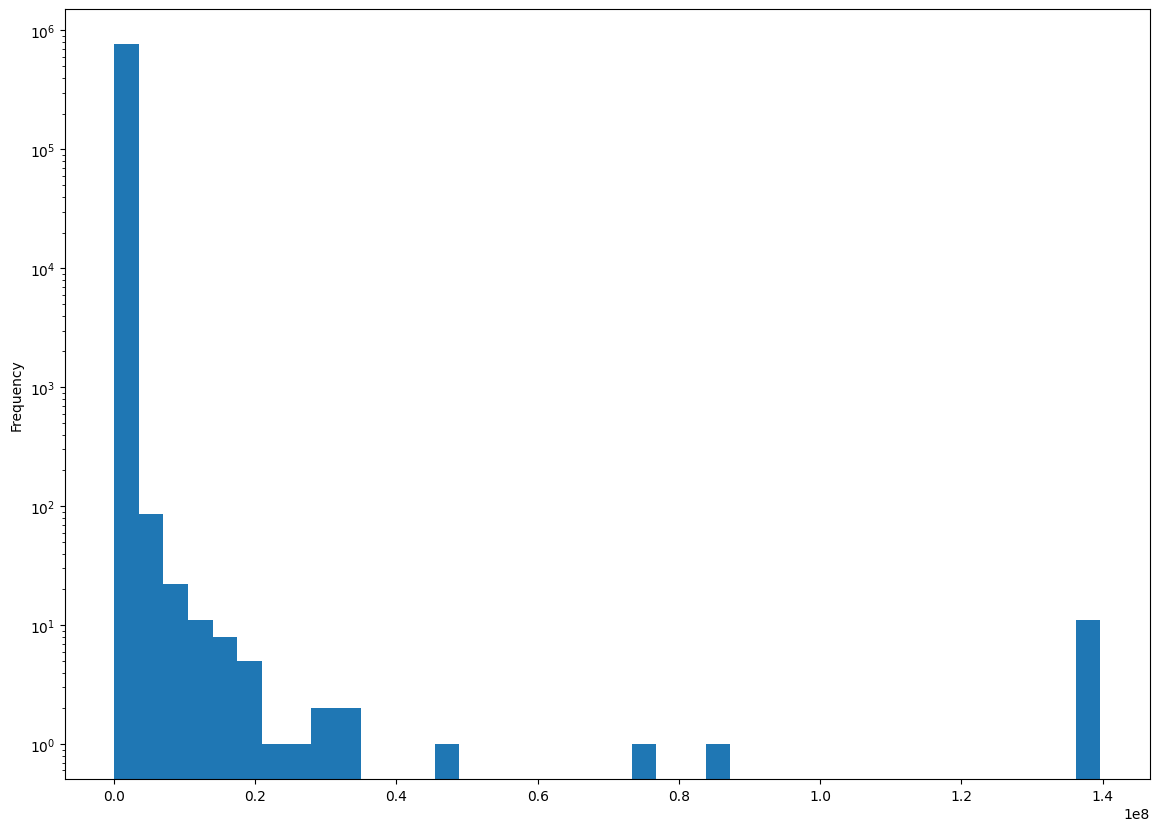

In [6]:
ax = df["m2_price"].plot.hist(figsize=(14,10), bins=40)
ax.set_yscale('log')

<Axes: ylabel='Frequency'>

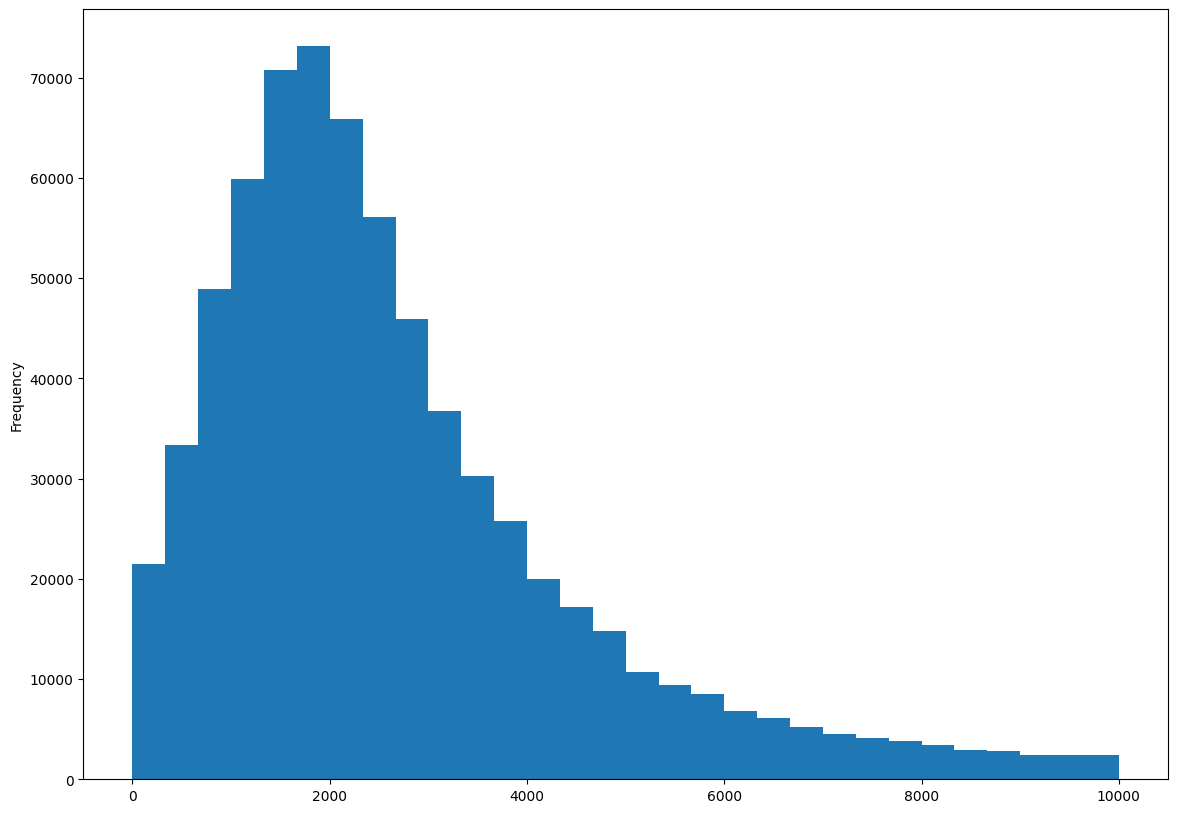

In [7]:
df[df["m2_price"] <= 1e4]["m2_price"].plot.hist(figsize=(14,10), bins=30)

# Save to csv

In [ ]:
df[["m2_price", "surface_reelle_bati", "surface_terrain", "valeur_fonciere", "longitude", "latitude"]].to_csv("../data/m2_price.csv")
df[df["m2_price"] <= 1e4].to_csv("../data/m2_price_upto1e4.csv")

# Heatmap creation

It simply shows the kernel density estimate of observed data points in geospatial coordinates. Computing KDE in spherical coordinates

Neighbors-based query (in particular a kernel density estimate) on geospatial data, using a Ball Tree built upon the Haversine distance metric – i.e. distances over points in latitude/longitude.

* https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html#sphx-glr-auto-examples-neighbors-plot-species-kde-py
* https://scikit-learn.org/stable/modules/density.html


In [12]:
grid_size = 0.5
lat_min, lat_max, lon_min, lon_max = 42.5, 51.1, -5.2, 8.2

xgrid = np.arange(lat_min, lat_max, grid_size)
ygrid = np.arange(lon_min, lon_max, grid_size)

X, Y = np.meshgrid(xgrid, ygrid[::-1])
xy = np.vstack([X.ravel(), Y.ravel()]).T

xy *= np.pi / 180.0

len(xy)

486

In [44]:
y

array([0.81022313, 0.80156871, 0.80156871, ..., 0.85283315, 0.85253103,
       0.85213304])

In [40]:
xi = linspace(lat_min, lat_max, 100) * np.pi / 180.0
yi = linspace(lon_min, lon_max, 100) * np.pi / 180.0

z = df["m2_price"].to_numpy()
y = df["latitude"].to_numpy() * np.pi / 180.0
x = df["longitude"].to_numpy() * np.pi / 180.0

zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

TypeError: Input z must be 2D, not 1D

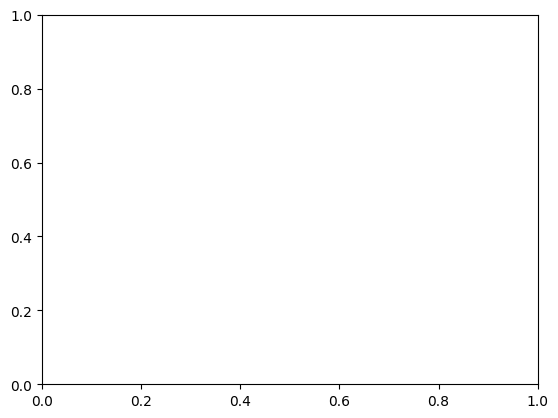

In [32]:
plt.contourf(xi, yi, zi, range(5000, int(np.nanmax(zi)) + 100, 100), cmap = plt.cm.jet)

In [14]:
kde = KernelDensity(bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree")

x_train = df[["latitude", "longitude"]].to_numpy()
x_weights = df["m2_price"]

kde.fit(np.radians(x_train), sample_weight=x_weights.to_numpy())

KernelDensity(algorithm='ball_tree', bandwidth=0.04, metric='haversine')

In [17]:
Z = np.exp(kde.score_samples(xy))

In [18]:
xyZ = np.hstack([xy, Z.reshape(-1,1)])
xyZ_df = pd.DataFrame(xyZ, columns=["latitude", "longitude", "price_by_m2"])
xyZ_df["latitude"] *= 180.0 / np.pi
xyZ_df["longitude"] *= 180.0 / np.pi

# export array to CSV file
xyZ_df.to_csv("../data/m2_price_heatmat.csv", index=False)

Bivariate spline fitting of data in spherical coordinates

If your data is given in spherical coordinates, $r = r(\theta, \phi)$,

`SmoothSphereBivariateSpline` and `RectSphereBivariateSpline` provide convenient analogs of `SmoothBivariateSpline` and `RectBivariateSpline`, respectively.

These classes ensure the periodicity of the spline fits for
* $ \theta \in [0, \pi] $ and,
* $ \phi \in [0, 2 \pi] $
 
and offer some control over the continuity at the poles.

> This routine constructs spline knot vectors automatically via the FITPACK
> algorithm. The spline knots may be placed away from the data points. For
> some data sets, this routine may fail to construct an interpolating spline,
> even if one is requested via ``s=0`` parameter. In such situations, it is
> recommended to use `bisplrep` / `bisplev` directly instead of this routine
> and, if needed, increase the values of ``nxest`` and ``nyest`` parameters
> of `bisplrep`.

I tried with a few examples and it seems the problem SmoothSphereBivariateSpline faces is the memory scaling. 

So if we have too many points on our grid it will memory overflow. This seems to be a more flexible method suitable for points irregularly dropped on sphere instead of regular grid like ours.

In [56]:
from scipy.interpolate import SmoothSphereBivariateSpline

# remove duplicates
# df_wduplicates = df[df["m2_price"] <= 1e4].reset_index(drop=True)
df_wduplicates = df.reset_index(drop=True)

rounding_factor = 2
df_wduplicates["latitude_r"] = df_wduplicates["latitude"].round(rounding_factor)
df_wduplicates["longitude_r"] = df_wduplicates["longitude"].round(rounding_factor)

df_wduplicates = df_wduplicates.groupby(by=["latitude_r", "longitude_r"])["m2_price"].mean()
df_wduplicates = df_wduplicates.reset_index()

print(len(df))
print(len(df_wduplicates))

data_std = df_wduplicates["m2_price"].std()
data_mean = df_wduplicates["m2_price"].mean()
data = ((df_wduplicates["m2_price"] - data_mean) / data_std).to_numpy()

thetas = (df_wduplicates["latitude_r"].to_numpy() + 90.0) * (np.pi / 180.0)
phis = (df_wduplicates["longitude_r"].to_numpy() + 180.0) * (np.pi / 180.0)


767804
144392


In [49]:
# sum((w(i)*(r(i) - s(theta(i), phi(i))))**2, axis=0) <= s
# Default s=len(w) which should be a good value if 1/w[i] is an estimate of the standard deviation of r[i].

lut = SmoothSphereBivariateSpline(theta=thetas, phi=phis, r=data, s=len(data), eps=1e-16)

In [50]:
lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()

lat_min = (lat_min + 90.0) * (np.pi / 180.0)
lat_max = (lat_max + 90.0) * (np.pi / 180.0)

lon_min = (lon_min + 180.0) * (np.pi / 180.0)
lon_max = (lon_max + 180.0) * (np.pi / 180.0)

fine_lats = np.linspace(lat_min, lat_max, 1000)
fine_lons = np.linspace(lon_min, lon_max, 1000)

data_smth = lut(fine_lats, fine_lons)

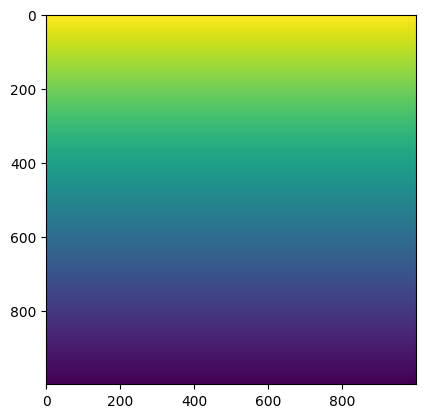

In [58]:
plt.imshow(data_smth * data_std + data_mean, interpolation='nearest')